# Visualisinfg National Lockdowns

In [69]:
from matplotlib.pylab import plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib import pyplot, lines
from matplotlib.patches import Patch
import matplotlib

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut

from scipy.stats import ttest_ind

import researchpy as rpy

from loguru import logger

from IPython.display import display, clear_output


import pandas as pd
import numpy as np

import seaborn as sns

import datetime 

import os
import sys
sys.path.insert(0, os.path.abspath('.'))

from lockdown_viz import plot_lockdown_model


%matplotlib inline

# Parameters

In [70]:
us_peak_model_dataset = '../data/processed/peak_model_ctp_covid.csv'
countries_peak_model_dataset = '../data/processed/peak_model_owid_covid.csv'

lockdown_dataset = '../data/expanded_lockdowns.pkl'

# Load Datasets

## Load Peak Datasets

In [71]:
logger.info('Load countries dataset @ %s' % countries_peak_model_dataset)

df = pd.read_csv(countries_peak_model_dataset, parse_dates=['date']).rename(columns={'country':'state'})

df.shape, df.state.nunique(), df.date.max(), df.columns

2020-07-28 15:55:18.073 | INFO     | __main__:<module>:1 - Load countries dataset @ ../data/processed/peak_model_owid_covid.csv


((38114, 25),
 207,
 Timestamp('2020-07-28 00:00:00'),
 Index(['aggregation', 'date', 'google_mobility_level_rolling_mean_stage',
        'new_deaths_rolling_mean_stage', 'new_cases_rolling_mean_stage',
        'country_id', 'state', 'country_code', 'continent', 'region',
        'new_cases', 'new_deaths', 'population', 'google_mobility_level',
        'google_mobility_level_by_pop', 'new_cases_rolling_mean',
        'new_deaths_rolling_mean', 'google_mobility_level_rolling_mean',
        'new_cases_rolling_mean_rel', 'new_deaths_rolling_mean_rel',
        'google_mobility_level_rolling_mean_rel',
        'new_cases_rolling_mean_stage_day', 'new_deaths_rolling_mean_stage_day',
        'google_mobility_level_rolling_mean_stage_day',
        'new_cases_rolling_mean_cummax'],
       dtype='object'))

## Eliminate aggregations without mobility data

In [72]:
with_mobility_data = df.groupby('aggregation').apply(lambda g: g['google_mobility_level_rolling_mean'].any())

df = df[df['aggregation'].isin(with_mobility_data[with_mobility_data].index)]

df.shape, df['state'].nunique()

((27801, 25), 132)

## Load Lockdown Dataset

In [74]:
logger.info('Loaded expanded lockdowns @ %s' % lockdown_dataset)

lockdowns = pd.read_pickle(lockdown_dataset).set_index('aggregation')
lockdowns.shape

2020-07-28 15:55:28.900 | INFO     | __main__:<module>:1 - Loaded expanded lockdowns @ ../data/expanded_lockdowns.pkl


(15533, 67)

In [75]:
current_lockdowns = lockdowns.sort_values(by='rebound_duration_days').groupby('aggregation').last()
current_lockdowns.shape

(195, 67)

In [76]:
df = df.sort_values(by='date')

In [77]:
df['during_lockdown'] = df['google_mobility_level_rolling_mean_stage'].isin(['D', 'H'])
df['after_lockdown'] = df['google_mobility_level_rolling_mean_stage'].isin(['B', 'N'])

mean_cases_in_lockdown = df[df['during_lockdown']].groupby('aggregation').apply(lambda g: g['new_cases_rolling_mean'].mean())

# Calculate cumulative mean cases/deaths during rebound.
df = df.set_index(['aggregation', 'date']).join(df[df['after_lockdown']].groupby('aggregation').apply(
    lambda g: g.set_index('date')['new_cases_rolling_mean'].expanding().mean()
), rsuffix='_cum').reset_index()

# Calculate the rebound ratio for each day of the rebound
rebound_ratios = pd.DataFrame(df[df['after_lockdown']].groupby('aggregation').apply(
    lambda g: g.set_index('date')['new_cases_rolling_mean_cum']/mean_cases_in_lockdown.loc[g.name])).rename(
    columns={'new_cases_rolling_mean_cum': 'rebound_ratio'})

df = df.set_index(['aggregation', 'date']).join(rebound_ratios).reset_index()

# Visualising Lockdowns

## The World

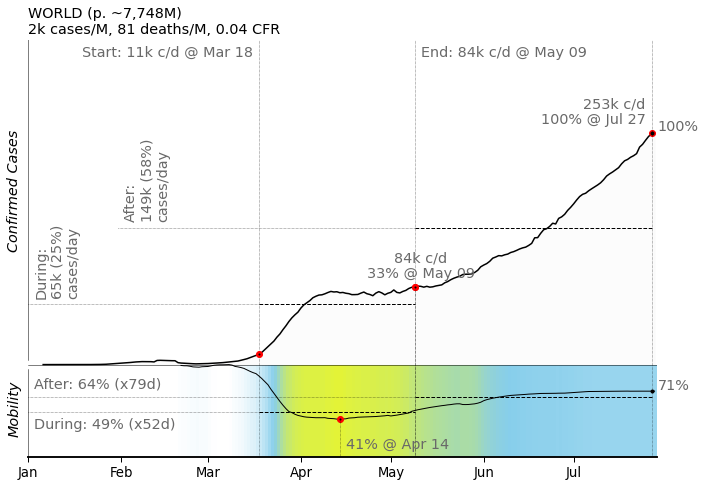

In [78]:
sns.set_context('talk', font_scale=.8)

width, height = 10, 7

fig, ax = plt.subplots(figsize=(width, height))

agg = 'world'

agg_data = df[df['aggregation']==agg].set_index('date')
agg_features = current_lockdowns.loc[agg]

plot_lockdown_model(ax, agg_data, agg_features, 'cases', 'google_mobility_level_rolling_mean_rel')
fig.tight_layout()



## The Continents

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


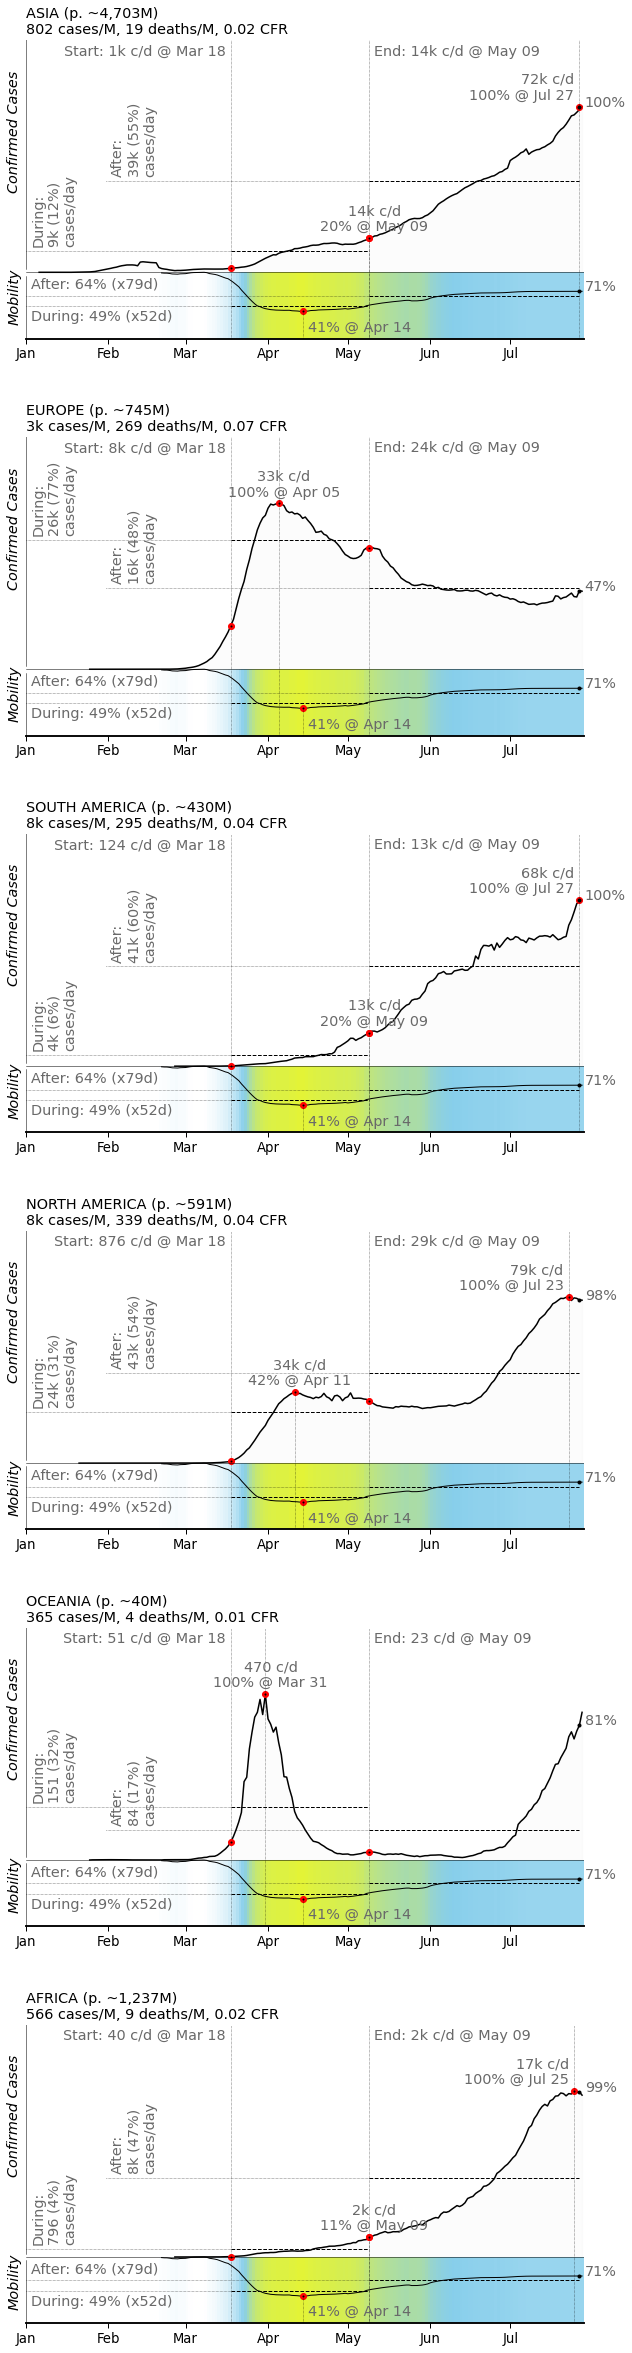

In [79]:
sns.set_context('talk', font_scale=.8)

aggs = df['continent'].dropna().unique()

fig, axs = plt.subplots(figsize=(width, height*len(aggs)), nrows=len(aggs), gridspec_kw={'hspace': .33})

for agg, ax in zip(aggs, axs):
    
    agg_data = df[df['aggregation']==agg].set_index('date')
    agg_features = current_lockdowns.loc[agg]

    plot_lockdown_model(ax, agg_data, agg_features, 'cases', 'google_mobility_level_rolling_mean_rel')

fig.tight_layout()




## The Regions 

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


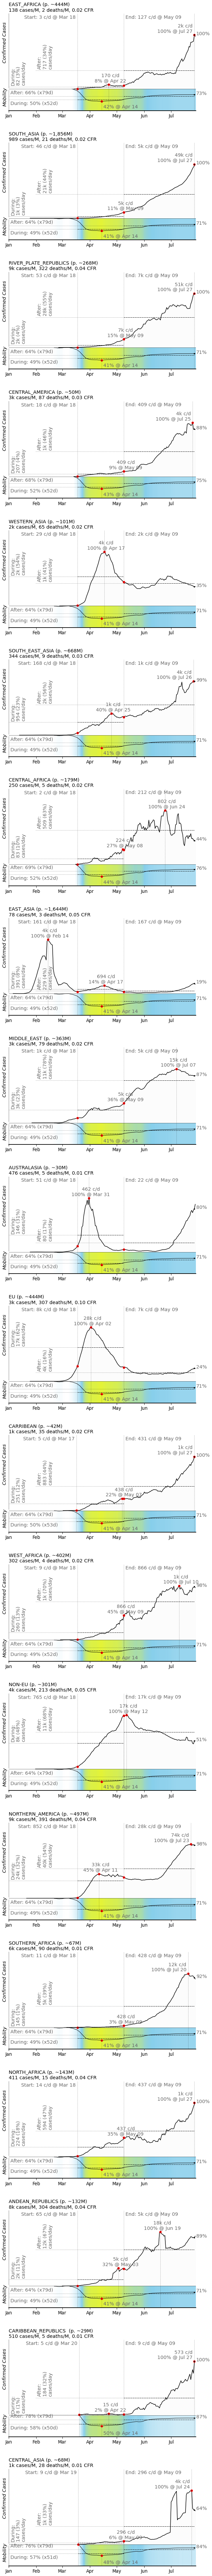

In [80]:
sns.set_context('talk', font_scale=.8)

aggs = set(df['region'].dropna().unique()).intersection(set(current_lockdowns.index))

fig, axs = plt.subplots(figsize=(width, height*len(aggs)), nrows=len(aggs), gridspec_kw={'hspace': .33})

for agg, ax in zip(aggs, axs):
    
    agg_data = df[df['aggregation']==agg].set_index('date')
    agg_features = current_lockdowns.loc[agg]

    plot_lockdown_model(ax, agg_data, agg_features, 'cases', 'google_mobility_level_rolling_mean_rel')

fig.tight_layout()





## Individual Countries

'Zimbabwe'

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


(3, 39, 116)

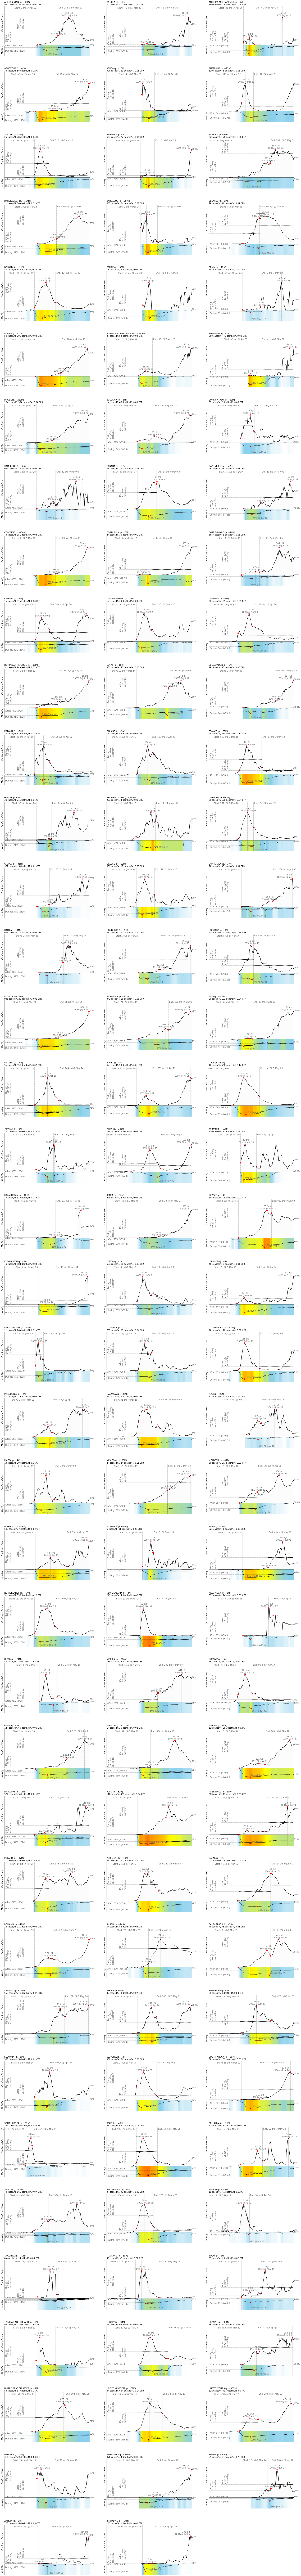

In [85]:
sns.set_context('talk', font_scale=.66)

with_country_id = df['country_id'].notnull()

aggs = sorted(set(df[with_country_id]['aggregation'].dropna().unique()).intersection(set(current_lockdowns.index)))

num_cols = 3
num_rows = 1+len(aggs)//num_cols

fig, axs = plt.subplots(figsize=(width*num_cols, height*num_rows), nrows=num_rows, ncols=num_cols, gridspec_kw={'hspace': .33})

axs = axs.flatten()

for ax in axs: ax.axis('off')

for agg, ax in zip(aggs, axs):
        
    clear_output(wait=True)
    display(agg)
    
    agg_data = df[df['aggregation']==agg].set_index('date')
    agg_features = current_lockdowns.loc[agg]

    plot_lockdown_model(ax, agg_data, agg_features, 'cases', 'google_mobility_level_rolling_mean_rel')

fig.tight_layout()

num_cols, num_rows, len(aggs)

# Comparing During/After Lockdown

In [111]:
min_cases = 5000
large_outbreaks = df.groupby('aggregation')['new_cases'].sum()[df.groupby('aggregation')['new_cases'].sum()>min_cases].index

aggs = sorted(set(df[with_country_id & (df['aggregation'].isin(large_outbreaks))]['aggregation'].dropna().unique()).intersection(set(current_lockdowns.index)))

use_lockdowns = current_lockdowns.loc[aggs].sort_values('rebound_ratio_cases', ascending=True)

use_lockdowns.shape, current_lockdowns.shape

((76, 67), (195, 67))

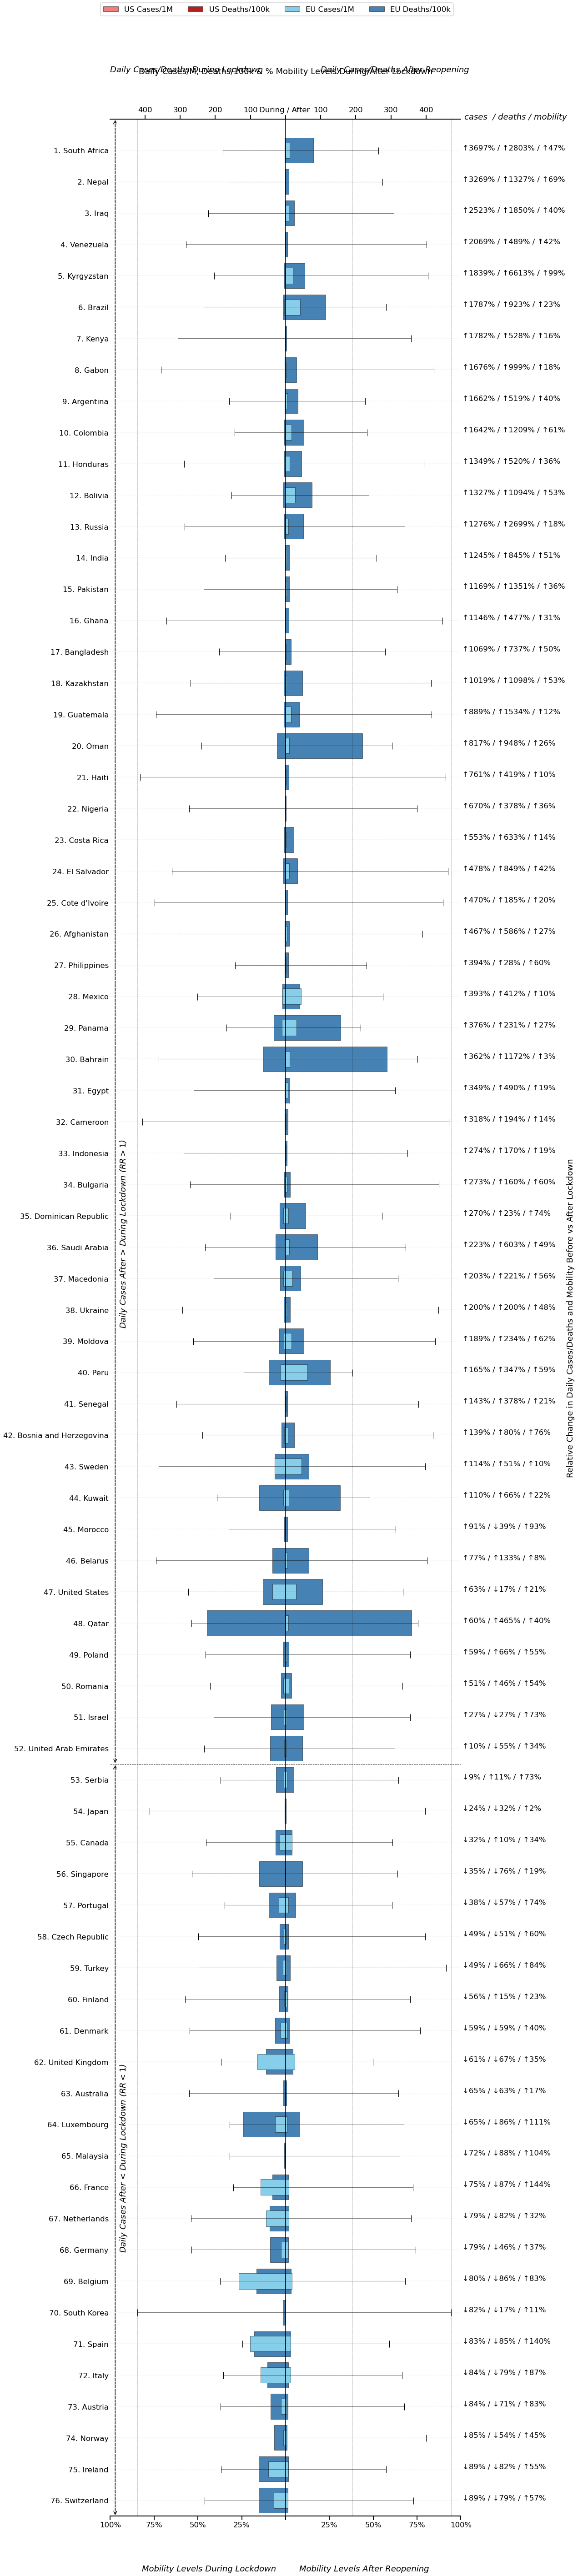

In [112]:
sns.set_context('talk', font_scale=1)


bar_height = .4

fig, ax = plt.subplots(figsize=(18, len(current_lockdowns)*bar_height))

# --- THE DAILY CASES/DEATHS BARS (ax)

# Colours for the US and EU barsl; a sequence of colours that match the sorting
# bar_colours1 = np.where(current_lockdowns['region']=='us', 'lightcoral', 'skyblue')
# bar_colours2 = np.where(current_lockdowns['region']=='us', 'firebrick', 'steelblue')

bar_colours1 = 'steelblue'
bar_colours2 = 'skyblue'

w1 = .8
((-use_lockdowns['lockdown_mean_value_cases_per_million'])-w1/2).plot(kind='barh', ax=ax, width=w1, color=bar_colours1, edgecolor='k', linewidth=.5)
(use_lockdowns['rebound_mean_value_cases_per_million']-w1/2).plot(kind='barh', ax=ax, width=w1, color=bar_colours1, edgecolor='k', linewidth=.5)

w2=.5
((-use_lockdowns['lockdown_mean_value_deaths_per_100k'])-w2/2).plot(kind='barh', ax=ax, width=w2, color=bar_colours2, edgecolor='k', linewidth=.5)
(use_lockdowns['rebound_mean_value_deaths_per_100k']-w2/2).plot(kind='barh', ax=ax, width=w2, color=bar_colours2, edgecolor='k', linewidth=.5)


# --- THE MOBILITY LEVELS (bx)
bx = ax.twiny()

# Plot the mobility indicators.
bx.plot(-use_lockdowns['lockdown_mean_mobility_level']*100, range(len(use_lockdowns['lockdown_mean_mobility_level'])), lw=0, marker='|', markersize=15, markerfacecolor='none', c='k')
bx.plot(use_lockdowns['rebound_mean_mobility_level']*100, range(len(use_lockdowns['rebound_mean_mobility_level'])), lw=0, marker='|', markersize=15, markerfacecolor='none', c='k')

# Connect the indicators
for y, (during, after) in enumerate(zip(use_lockdowns['lockdown_mean_mobility_level'].values, use_lockdowns['rebound_mean_mobility_level'].values)):
    bx.plot([-during*100, after*100], [y]*2, c='k', lw=.5)
    
# Mark the min/max relative mobility during/after for reference
bx.axvline(-use_lockdowns['lockdown_mean_mobility_level'].min()*100, lw=0.5, ls=':', c='k')
bx.axvline(-use_lockdowns['lockdown_mean_mobility_level'].max()*100, lw=0.5, ls=':', c='k')

bx.axvline(use_lockdowns['rebound_mean_mobility_level'].min()*100, lw=0.5, ls=':', c='k')
bx.axvline(use_lockdowns['rebound_mean_mobility_level'].max()*100, lw=0.5, ls=':', c='k')


    
# --- RELATIVE CHANGE INDICATORS (cx)
cx = ax.twinx()

# Add labels to indicate relative change in cases before/after lockdown.
cx_labels = []

def gen_rel_label(v):
    if (v != np.nan) & (v != np.inf):
        if v>0: return '↑{}%'.format(int(abs(v)))
        elif v<0: return '↓{}%'.format(int(abs(v)))
    return '↔0%'

for y, (_, (rel_cases, rel_deaths, rel_mobility)) in enumerate(use_lockdowns[['rebound_ratio_cases', 'rebound_ratio_deaths', 'rebound_ratio_mobility_level']].iterrows()):
    
    cx_label = '{} / {} / {}'.format(gen_rel_label((rel_cases-1)*100), gen_rel_label((rel_deaths-1)*100), gen_rel_label((rel_mobility-1)*100))
    cx_labels.append(cx_label)



# --- CONFIGURE THE AXES

# The daily cases/deaths axis
ax.xaxis.tick_top()

ax.set_xlim(-499, 499)
ax.set_xticks(np.arange(-400, 451, 100))
ax.set_xticklabels(['400', '300', '200', '100', 'During / After ', '100', '200', '300', '400'])
ax.set_ylim(-.5, len(use_lockdowns))

# Plot the vertical centre line separating the before and after data.
ax.axvline(0, lw=1.5, c='k')

# Add the state labels with a ranking number
state_labels = ['{}. {}'.format((len(use_lockdowns)-rank), state) for rank, state in enumerate(use_lockdowns.reset_index()['location'])]
ax.set_yticklabels(state_labels)
ax.set_ylabel('')

# Add annotations to separate growers vs decliners
crossing = use_lockdowns['rebound_ratio_cases'].index.get_loc(use_lockdowns['rebound_ratio_cases'][use_lockdowns['rebound_ratio_cases']>1].index[0])-0.5
ax.axhline(crossing, lw=1, c='k', ls='--')
ax.axhline(-.5, lw=1.5, c='k')

ax.annotate(s='', xy=(-485, crossing), xytext=(-485, ax.get_ylim()[1]), arrowprops=dict(arrowstyle='<->', linestyle="dashed"))
ax.text(-475, crossing+14, 'Daily Cases After > During Lockdown ($RR>1$)', rotation=90, style='italic')

ax.annotate(s='', xy=(-485,crossing), xytext=(-485, -.5), arrowprops=dict(arrowstyle='<->', linestyle="dashed"))
ax.text(-475, 8, 'Daily Cases After < During Lockdown ($RR<1$)', rotation=90, style='italic')

# Add the main titles for the bar charts
ax.set_title('Daily Cases/M, Deaths/100k & % Mobility Levels During/After Lockdown', pad=100)
ax.text(-500, ax.get_ylim()[1]+1.5, 'Daily Cases/Deaths During Lockdown', style='italic')
ax.text(100, ax.get_ylim()[1]+1.5, 'Daily Cases/Deaths After Reopening', style='italic')


# The mobility axis
bx.xaxis.tick_bottom()

bx.set_xlim(-100, 100)
bx.set_xticks(np.arange(-100, 101, 25))
bx.set_xticklabels(['100%', '75%', '50%', '25%', '', '25%', '50%', '75%', '100%'])

# Labels
bx.text(-82, ax.get_ylim()[0]-1.75, 'Mobility Levels During Lockdown', style='italic')
bx.text(82, ax.get_ylim()[0]-1.75, 'Mobility Levels After Reopening', style='italic', ha='right')


# The relative change axis (righ-hand y-axis)
cx.set_ylim(*ax.get_ylim())
cx.set_yticks(np.arange(.1, len(cx_labels), 1))

cx.set_yticklabels(cx_labels)
cx.set_ylabel('Relative Change in Daily Cases/Deaths and Mobility Before vs After Lockdown')
cx.text(ax.get_xlim()[1]+10, ax.get_ylim()[1], 'cases  / deaths / mobility', style='italic')



# Build the Legend
legend_elements = [
    Patch(facecolor='lightcoral', edgecolor='k',lw=.5, label='US Cases/1M'),
    Patch(facecolor='firebrick', edgecolor='k',lw=.5, label='US Deaths/100k'),
    Patch(facecolor='skyblue', edgecolor='k',lw=.5, label='EU Cases/1M'),
    Patch(facecolor='steelblue', edgecolor='k',lw=.5, label='EU Deaths/100k')
]

ax.legend(handles=legend_elements, ncol=4, bbox_to_anchor=(.99, 1.05), frameon=True)

    
    
# Remove the frame and the ytick marks
for xx in [ax, bx, cx]:
    xx.spines['right'].set_visible(False)
    xx.spines['left'].set_visible(False)
    xx.tick_params(axis = 'y', which = 'major', width=0, length=0)

# Add gridlines
ax.grid(True, axis='y', ls=':', lw=.33)

fig.tight_layout()

# fig.savefig('../graphs/eu_us_ranking.png', **fig_params)

# logger.info('Saving chart -> %s' % '../graphs/eu_us_ranking.png')

In [113]:
(use_lockdowns['rebound_ratio_cases']>1).mean(), (use_lockdowns.groupby('region')['rebound_ratio_cases'].apply(lambda g: (g>1).mean()))

(0.6842105263157895,
 region
 andean_republics         1.000000
 australasia              0.000000
 caribbean_republics      1.000000
 carribean                1.000000
 central_africa           1.000000
 central_america          1.000000
 central_asia             1.000000
 east_africa              1.000000
 east_asia                0.000000
 eu                       0.235294
 middle_east              1.000000
 non-eu                   0.600000
 north_africa             1.000000
 northern_america         0.666667
 river_plate_republics    1.000000
 south_asia               1.000000
 south_east_asia          0.500000
 southern_africa          1.000000
 west_africa              1.000000
 western_asia             0.000000
 Name: rebound_ratio_cases, dtype: float64)

In [115]:
use_lockdowns.groupby(use_lockdowns['rebound_ratio_cases']>1)['lockdown_mean_mobility_level'].mean()

rebound_ratio_cases
False    0.462593
True     0.508701
Name: lockdown_mean_mobility_level, dtype: float64

# Statistical Comparisons of Key Lockdown Features
Compare key features of lockdowns between increasing and decreasing rebounds.

In [116]:

increasing_rebounds = use_lockdowns['is_increasing_rebound']
strong_lockdown = use_lockdowns['is_strong_lockdown']
conservative_lockdown = use_lockdowns['is_conservative_rebound']


In [117]:
def merge_mean_std(data): return '{:.2f} ± {:.2f}'.format(*data)
def merge_t_p(data): return 'p={:.2f}, t={:.2f}'.format(data[1], data[0])

## Successful vs Unsuccessful Reopenings

In [119]:
key_features = [
    'lockdown_mean_value_cases_per_million',
    'lockdown_exit_level_cases', 'lockdown_days_from_peak_cases',
    'lockdown_mean_mobility_level', 'rebound_mean_mobility_level'
]

increasing_rebound = use_lockdowns.set_index(use_lockdowns['rebound_ratio_cases']>1)[key_features].loc[True]
decreasing_rebound = use_lockdowns.set_index(use_lockdowns['rebound_ratio_cases']>1)[key_features].loc[False]

pd.concat({
    '$RR\leq1$': decreasing_rebound.agg(['mean', 'std']).T.apply(merge_mean_std, axis=1),
    '$RR>1$': increasing_rebound.agg(['mean', 'std']).T.apply(merge_mean_std, axis=1), 
    'One-sided $t$ test': pd.DataFrame(ttest_ind(increasing_rebound, decreasing_rebound), columns=key_features).T.apply(merge_t_p, axis=1)
}, axis=1)

$RR\leq1$         $RR>1$  \
lockdown_mean_value_cases_per_million  43.07 ± 30.44  16.81 ± 34.64   
lockdown_exit_level_cases                0.38 ± 0.23    0.86 ± 0.21   
lockdown_days_from_peak_cases          23.96 ± 11.44    6.21 ± 9.49   
lockdown_mean_mobility_level             0.46 ± 0.14    0.51 ± 0.15   
rebound_mean_mobility_level              0.70 ± 0.10    0.69 ± 0.15   

                                      One-sided $t$ test  
lockdown_mean_value_cases_per_million    p=0.00, t=-3.19  
lockdown_exit_level_cases                 p=0.00, t=8.97  
lockdown_days_from_peak_cases            p=0.00, t=-7.10  
lockdown_mean_mobility_level              p=0.21, t=1.27  
rebound_mean_mobility_level              p=0.72, t=-0.36

# Strong Lockdowns & Conservative Rebounds

In [120]:
# Over-ride for the US/EU features
strong_threshold, conservative_threshold = 0.50, 0.70
use_lockdowns['is_strong_lockdown'] = use_lockdowns['lockdown_mean_mobility_level'] < strong_threshold
use_lockdowns['is_conservative_rebound'] = use_lockdowns['rebound_mean_mobility_level'] < conservative_threshold


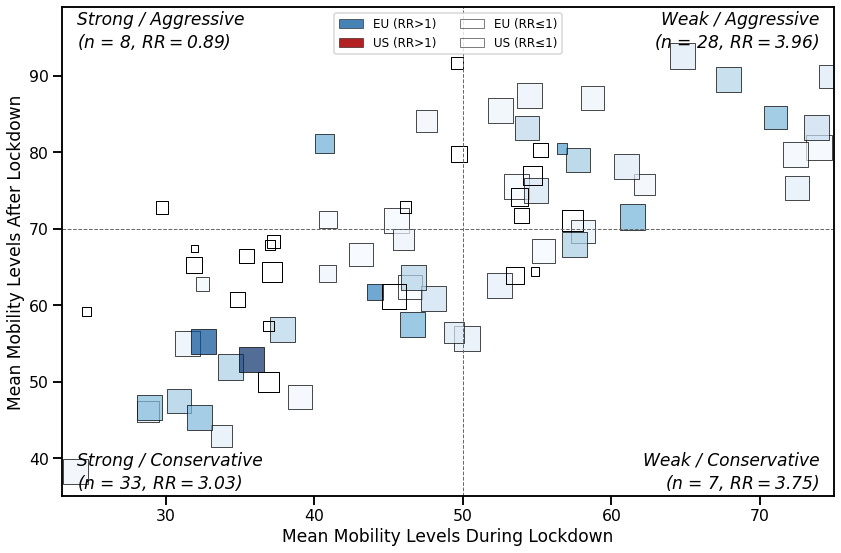

In [123]:
sns.set_context('talk', font_scale=.95)

fig, ax = plt.subplots(figsize=(12, 8))



# Colour maps for the EU & US
cmap = plt.cm.Blues
norm = matplotlib.colors.Normalize(vmin=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

colours = cmap(norm(use_lockdowns[increasing_rebounds]['rebound_ratio_cases']))


# --- THE MAIN SCATTER PLOTS
size_scale = 1.45
square_adj = .8

# The increasing rebounds
ax.scatter(use_lockdowns[increasing_rebounds]['lockdown_mean_mobility_level']*100, use_lockdowns[increasing_rebounds]['rebound_mean_mobility_level']*100, 
           s=use_lockdowns[increasing_rebounds]['lockdown_exit_level_cases']*100**size_scale*square_adj, 
           marker='s', edgecolor='k', lw=1, label='US', color=colours, alpha=.7)

ax.scatter(use_lockdowns[~increasing_rebounds]['lockdown_mean_mobility_level']*100, use_lockdowns[~increasing_rebounds]['rebound_mean_mobility_level']*100, 
           s=use_lockdowns[~increasing_rebounds]['lockdown_exit_level_cases']*100**size_scale*square_adj, 
           marker='s', edgecolor='k', lw=1, color='none')



# --- ANNOTATIONS

# The rebound ratios converted to % increase/decrease
rebound_ratios_by_quadrant = ((use_lockdowns.groupby(
    ['is_strong_lockdown', 'is_conservative_rebound'])['rebound_ratio_cases'].median()))

frac_pos_rebounds_by_quadrant = use_lockdowns.groupby(
    ['is_strong_lockdown', 'is_conservative_rebound'])['is_increasing_rebound'].mean()

n_by_quadrant = use_lockdowns.groupby(
    ['is_strong_lockdown', 'is_conservative_rebound'])['is_increasing_rebound'].size()

# A label helper
def add_arrow(n): 
    label = '↑{}'.format(int(n)) if n>0 else '↓{}'.format(int(abs(n)))
    return label

strong_aggressive_label = 'Strong / Aggressive\n(n = {}, $RR=${:.2f})'.format(
    n_by_quadrant.loc[True].loc[False], rebound_ratios_by_quadrant.loc[True].loc[False])


strong_conservative_label = 'Strong / Conservative\n(n = {}, $RR=${:.2f})'.format(
    n_by_quadrant.loc[True].loc[True], rebound_ratios_by_quadrant.loc[True].loc[True])


weak_aggressive_label = 'Weak / Aggressive\n(n = {}, $RR=${:.2f})'.format(
    n_by_quadrant.loc[False].loc[False], rebound_ratios_by_quadrant.loc[False].loc[False])


weak_conservative_label = 'Weak / Conservative\n(n = {}, $RR=${:.2f})'.format(
    n_by_quadrant.loc[False].loc[True], rebound_ratios_by_quadrant.loc[False].loc[True])



# Need to set the axis limits before plotting the labels
ax.set_xlim(23, 75)
ax.set_ylim(35, 99)

ax.text(ax.get_xlim()[0]+1, ax.get_ylim()[1]-.5, strong_aggressive_label, style='italic', ha='left', va='top')
ax.text(ax.get_xlim()[0]+1, ax.get_ylim()[0]+.5, strong_conservative_label, style='italic', ha='left', va='bottom')
ax.text(ax.get_xlim()[1]-1, ax.get_ylim()[1]-.5, weak_aggressive_label, style='italic', ha='right', va='top')
ax.text(ax.get_xlim()[1]-1, ax.get_ylim()[0]+.5, weak_conservative_label, style='italic', ha='right', va='bottom')

# # Highlight specific states
# highlights = [
#     ('District of Columbia', 3, -3, 'center'), 
#     ('New York', -6, -6, 'center'),
#     ('Arkansas', -1.5, 6, 'center'),
#     ('Arizona', 4, -6, 'center'),
#     ('Texas', 7, -3, 'center'),
#     ('California', 0, -10, 'center'),
#     ('Hawaii', -1, -10, 'center'),
#     ('Florida', 5, -7, 'center'),
    
#     ('Ireland', -5, -5, 'right'),
#     ('Spain', 1, 5, 'center'),
#     ('Italy', 0, -4.5, 'left'),
#     ('Sweden', -5, -7, 'center'),

#     ('Slovenia', -5, 7, 'center'),
#     ('Bulgaria', -1, 2, 'left'),
#     ('Greece', -8, 3, 'center'),
# ]

# for highlight, x_offset, y_offset, ha, in highlights:
#     state = eu_us_features.loc[highlight]
#     x, y = state['lockdown_mean_mobility_level']*100, state['rebound_mean_mobility_level']*100
#     label = '{}\n($EF=${}%, $RR=${:.1f})'.format(
#         highlight, 
#         int(100*eu_us_features.loc[highlight]['lockdown_exit_level_cases']), 
#         (eu_us_features.loc[highlight]['rebound_ratio_cases'])
#     )
    
#     ax.annotate(
#         label, xy=(x, y), xytext=(x+3+x_offset, y+y_offset), ha=ha,
#         arrowprops=dict(facecolor='k', arrowstyle='-|>, head_width=.25', lw=.5), fontsize=12, style='italic',
#     )
    
#     ax.scatter([x], [y], s=3, marker='o', color='k')


# The separating lines
ax.axvline(strong_threshold*100, lw=1, ls='--', c='dimgrey')
ax.axhline(conservative_threshold*100, lw=1, ls='--', c='dimgrey')

ax.set_xlabel('Mean Mobility Levels During Lockdown')
ax.set_ylabel('Mean Mobility Levels After Lockdown')

# Build the Legend
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='k',lw=.5, label='EU (RR>1)'),
    Patch(facecolor='firebrick', edgecolor='k',lw=.5, label='US (RR>1)'),
    Patch(facecolor='none', edgecolor='k',lw=.5, label='EU (RR≤1)'),
    Patch(facecolor='none', edgecolor='k',lw=.5, label='US (RR≤1)'),
]

ax.legend(handles=legend_elements, ncol=2, loc='upper center', frameon=True, fontsize=12)


fig.tight_layout()


# fig.savefig('../graphs/eu_us_scatter.png', **fig_params)

# logger.info('Saving chart -> %s' % '../graphs/eu_us_scatter.png')

In [39]:
eu_us_features.groupby('is_strong_lockdown').apply(lambda g: (~g['is_increasing_rebound']).mean())

is_strong_lockdown
False    0.214286
True     0.904762
dtype: float64

In [40]:
eu_us_features.groupby('is_strong_lockdown')['lockdown_days_from_peak_cases'].mean()

is_strong_lockdown
False    10.000000
True     24.142857
Name: lockdown_days_from_peak_cases, dtype: float64

In [41]:
rpy.ttest(eu_us_features[in_eu]['lockdown_mean_mobility_level'], eu_us_features[in_us]['lockdown_mean_mobility_level'])

(                       Variable     N      Mean        SD        SE  \
 0  lockdown_mean_mobility_level  26.0  0.452686  0.109288  0.021433   
 1  lockdown_mean_mobility_level  51.0  0.584636  0.066016  0.009244   
 2                      combined  77.0  0.540082  0.103640  0.011811   
 
    95% Conf.  Interval  
 0   0.408544  0.496828  
 1   0.566069  0.603204  
 2   0.516558  0.563605  ,
                                   Independent t-test  results
 0  Difference (lockdown_mean_mobility_level - loc...  -0.1320
 1                              Degrees of freedom =   75.0000
 2                                               t =   -6.5983
 3                           Two side test p value =    0.0000
 4                          Difference < 0 p value =    0.0000
 5                          Difference > 0 p value =    1.0000
 6                                       Cohen's d =   -1.5900
 7                                       Hedge's g =   -1.5741
 8                                   G

In [42]:
rpy.ttest(eu_us_features[in_eu]['rebound_mean_mobility_level'], eu_us_features[in_us]['rebound_mean_mobility_level'])

(                      Variable     N      Mean        SD        SE  95% Conf.  \
 0  rebound_mean_mobility_level  26.0  0.722411  0.071044  0.013933   0.693715   
 1  rebound_mean_mobility_level  51.0  0.728373  0.086633  0.012131   0.704007   
 2                     combined  77.0  0.726360  0.081277  0.009262   0.707912   
 
    Interval  
 0  0.751106  
 1  0.752739  
 2  0.744808  ,
                                   Independent t-test  results
 0  Difference (rebound_mean_mobility_level - rebo...  -0.0060
 1                              Degrees of freedom =   75.0000
 2                                               t =   -0.3026
 3                           Two side test p value =    0.7630
 4                          Difference < 0 p value =    0.3815
 5                          Difference > 0 p value =    0.6185
 6                                       Cohen's d =   -0.0729
 7                                       Hedge's g =   -0.0722
 8                                   Glass

In [43]:
eu_us_features.groupby(['region', 'is_strong_lockdown', 'is_conservative_rebound']).size().unstack()

is_conservative_rebound    False  True 
region is_strong_lockdown              
eu     False                 9.0    NaN
       True                  8.0    9.0
us     False                31.0   16.0
       True                  NaN    4.0

In [44]:
eu_us_features.groupby(['is_strong_lockdown']).size()/len(eu_us_features)

is_strong_lockdown
False    0.727273
True     0.272727
dtype: float64

In [45]:
(eu_us_features.groupby(['region', 'is_strong_lockdown']).size()/eu_us_features.groupby(['region']).size()).unstack()

is_strong_lockdown     False     True 
region                                
eu                  0.346154  0.653846
us                  0.921569  0.078431

In [46]:
eu_us_features.groupby('region')[['lockdown_mean_mobility_level', 'rebound_mean_mobility_level']].mean()

lockdown_mean_mobility_level  rebound_mean_mobility_level
region                                                           
eu                          0.452686                     0.722411
us                          0.584636                     0.728373

In [47]:
ttest_ind(eu_us_features[in_eu]['lockdown_mean_mobility_level'], eu_us_features[in_us]['lockdown_mean_mobility_level']), ttest_ind(eu_us_features[in_eu]['rebound_mean_mobility_level'], eu_us_features[in_us]['rebound_mean_mobility_level'])

(Ttest_indResult(statistic=-6.598273592594042, pvalue=5.205554661852089e-09),
 Ttest_indResult(statistic=-0.3026075612306276, pvalue=0.7630266303980532))